## <font color='#2F4F4F'> Data Cleaning & Preparation</font>

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm

%matplotlib inline

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

In [2]:
# load and preview dataset
file_name = '../data/AdSmartABdata.csv'
df =pd.read_csv(file_name)
df.sample(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
780,190665ba-3d25-476e-82bd-eeb240a14b49,control,2020-07-09,16,Samsung SM-A505FN,6,Samsung Internet,0,0
1227,2812a04b-4690-457d-bcaa-4d403681f324,control,2020-07-09,13,Generic Smartphone,6,Chrome Mobile,0,0
4636,93d3fc08-e630-48d8-beb3-45170e92a18e,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [3]:
# check dataset shape
df.shape

(8077, 9)

Our dataset has 8077 records and 9 variables.

In [4]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [7]:
# check for missing values
df.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [8]:
# preview variable datatypes
df.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

In [9]:
# check for duplicates
df.duplicated().sum()

0

## A/B testing with Machine Learning  

Algorithms
1. Logistic Regression
2. Decison Trees italicised text
3. XGboost

In [10]:
df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [11]:
data=df.copy()

### Feature Engineering & Test for Multicollinearity
* Before we can carry out the test for multicollinearity (a requirement for logistic regression), we need to convert some categorical values to numeric values and restructure some features.

We will drop the auction id column since it just represnts randomly assigned numbers

In [12]:
data.drop('auction_id',axis=1,inplace=True)

For the target variable,we will have a column representing the response of the user i.e  yes or no.So we will drop those who didn't respond

In [13]:
data=data[~(data[['yes','no']] == 0).all(axis=1)]
data.sample(3)

,experiment,date,hour,device_make,platform_os,browser,yes,no
1990,control,2020-07-04,20,Samsung SM-G970F,6,Facebook,1,0
5944,exposed,2020-07-09,8,Generic Smartphone,6,Chrome Mobile,1,0
1070,exposed,2020-07-08,16,Generic Smartphone,6,Chrome Mobile,0,1


In [14]:
data['response']=np.where(data['yes']==1,1,0)
data.drop('yes',axis=1,inplace=True)
data.drop('no',axis=1,inplace=True)
data.sample(8)

,experiment,date,hour,device_make,platform_os,browser,response
2347,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0
3621,control,2020-07-04,5,Nokia$2$3,6,Chrome Mobile,0
4841,exposed,2020-07-07,20,Generic Smartphone,6,Chrome Mobile,1
726,control,2020-07-03,15,Samsung SM-J330FN,6,Samsung Internet,0
1226,exposed,2020-07-09,13,Nokia$2$3,6,Chrome Mobile WebView,1
2994,exposed,2020-07-08,22,Samsung SM-G960F,6,Facebook,0
2631,control,2020-07-03,15,iPhone,5,Mobile Safari UI/WKWebView,0
7782,exposed,2020-07-09,17,Samsung SM-G975F,6,Chrome Mobile WebView,1


We now need to deal with the categorical variables..experiment,device_make and browser

In [15]:
experiment={'experiment':
            {'exposed':1,'control':0}
            }
data.replace(experiment,inplace=True)
data['experiment'].head(5)


2     1
16    1
20    1
23    0
27    0
Name: experiment, dtype: int64

In [16]:
data=pd.get_dummies(data,columns=['browser'])

In [17]:
data.head(3)

,experiment,date,hour,device_make,platform_os,response,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
2,1,2020-07-05,2,E5823,6,0,0,0,1,0,0,0,0,0
16,1,2020-07-04,16,Generic Smartphone,6,1,0,1,0,0,0,0,0,0
20,1,2020-07-06,8,Generic Smartphone,6,0,0,1,0,0,0,0,0,0


In [18]:
data.device_make.value_counts()
searchfor=['Generic Smartphone','Samsung','iPhone','LG-$2','HTC','POT-LX1','Nokia','OnePlus','Pixel 3a','XiaoMi','CLT-L09' ]

data.loc[~(data['device_make'].astype(str).str.contains('|'.join(searchfor))), 'device_make'] = 'Others'

In [19]:
data['device_make'].value_counts().head(40)

Generic Smartphone     719
Others                  89
Samsung SM-G960F        45
Samsung SM-G950F        35
Samsung SM-G973F        22
Samsung SM-A202F        18
iPhone                  18
Samsung SM-G930F        16
Samsung SM-G975F        15
Samsung SM-A405FN       14
Samsung SM-A105FN       13
Samsung SM-A505FN       11
Samsung SM-G935F        11
Samsung SM-G965F        11
Nokia undefined$2$3     11
Samsung SM-J330FN       10
Samsung SM-A705FN       10
Samsung SM-G970F        10
Nokia$2$3                9
Samsung SM-A520F         8
POT-LX1                  8
Samsung SM-A320FL        8
Samsung SM-J530F         7
Samsung SM-J600FN        6
Samsung $2               6
Samsung SM-G920F         5
CLT-L09                  5
Samsung SM-A530F         5
Samsung SM-G900F         5
Samsung SM-A300FU        5
Samsung SM-N960F         5
Samsung SM-A600FN        4
Samsung SM-G980F         4
Samsung SM-G986B         4
Samsung SM-G981B         4
Samsung SM-G955F         4
Samsung SM-N976B         3
S

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["device_make"] = label_encoder.fit_transform(data["device_make"])
data.head(5)

,experiment,date,hour,device_make,platform_os,response,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
2,1,2020-07-05,2,12,6,0,0,0,1,0,0,0,0,0
16,1,2020-07-04,16,1,6,1,0,1,0,0,0,0,0,0
20,1,2020-07-06,8,1,6,0,0,1,0,0,0,0,0,0
23,0,2020-07-08,4,17,6,1,0,0,0,0,1,0,0,0
27,0,2020-07-03,15,1,6,0,0,1,0,0,0,0,0,0


In [21]:
data.head(5)
data.drop('date',axis=1,inplace=True)

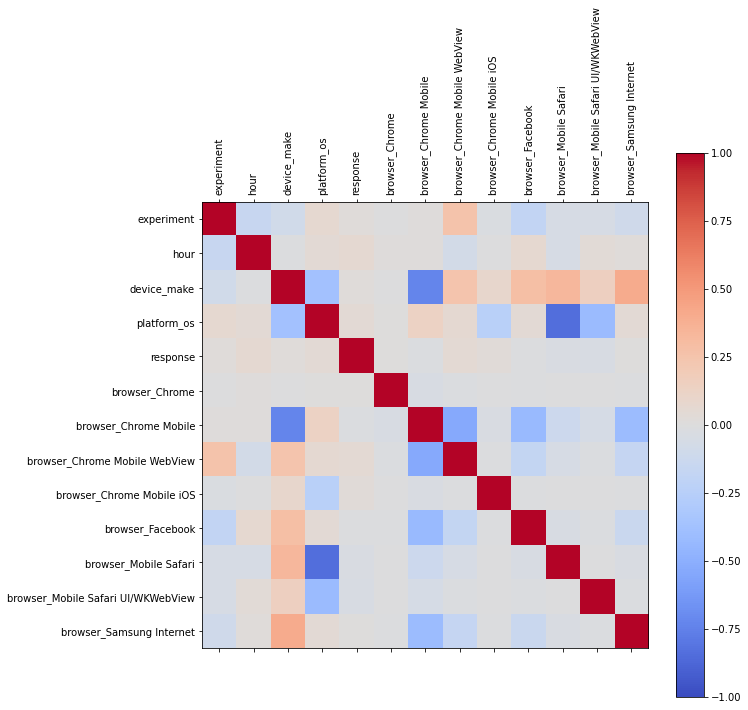

In [22]:
# checking the correlations between the numerical variables

corr = data.corr()

# plotting the correlations onto a heatmap
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### Splitting data 
* Split the data into 70% training, 20% validation, and 10% test sets.


In [23]:
# dividing our dataset into features (X) and target (y)
y = data.iloc[:,-1].values  # Independent/predictor variables
X = data.iloc[:, :-1].values


from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.7,random_state = 0)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.22,train_size =0.78,random_state = 0)

In [24]:
# performing feature scaling on our training data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fitting and transforming X_train while transforming X_test
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_cv = scaler.transform(x_cv)

### Apply ML and train using 5-fold CV
* Train a machine learning model using 5-fold cross validation the following 3 different algorithms:
 * Logistic Regression 
 * Decision Trees
 * XGBoost



In [29]:
# 5-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()

print(cross_val_score(logreg, x_train, y_train, cv=5, scoring='accuracy').mean())

scores=cross_val_score(logreg, x_train, y_train, cv=5, scoring='accuracy')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

0.9985185185185186
Scores: [1.         1.         1.         1.         0.99259259]
Mean: 0.9985185185185186
Standard Deviation: 0.002962962962962967


In [31]:
# 5-fold cross-validation with XGbooost
from xgboost import XGBClassifier

xgb_cv = XGBClassifier(n_estimators=100)

print(cross_val_score(xgb_cv, x_train, y_train, cv=5, scoring = "accuracy").mean())

scores = cross_val_score(xgb_cv, x_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

0.9970370370370369
Scores: [1.         1.         1.         0.99259259 0.99259259]
Mean: 0.9970370370370369
Standard Deviation: 0.003628873693012121


In [27]:
# 5-fold cross-validation with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

print(cross_val_score(decision_tree, x_train, y_train, cv=5, scoring='accuracy').mean())

scores = cross_val_score(decision_tree, x_train, y_train, cv=5, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

0.9985185185185186
Scores: [1. 1. 1. 1. 1.]
Mean: 1.0
Standard Deviation: 0.0


### Loss Function
Define the appropriate loss function  for the model using the validation data. 

In [32]:
# from sklearn.metrics import log_loss
# # classification report for Logistic Regression
# print("Logistic Regression classification report:")
# print(log_loss(y_test, logistic_y_prediction))


# # classification report for Decision Tree Classifier
# print("Decision Tree classification report:")
# print(log_loss(y_test, decision_y_prediction))

# # classification report for Decision Tree Classifier
# print("XGBoost report:")
# print(log_loss(y_test, xgb_y_prediction))

In [33]:
logreg.fit(x_cv, y_cv)
decision_tree.fit(x_cv, y_cv)
xgb_cv.fit(x_cv, y_cv)


# making predictions
logistic_y_prediction = logreg.predict(x_test) 
decision_y_prediction = decision_tree.predict(x_test) 
xgb_y_prediction = xgb_cv.predict(x_test) 


In [34]:
# printing the classification report for each classifier to assess performance
from sklearn.metrics import classification_report

# classification report for Logistic Regression
print("Logistic Regression classification report:")
print(classification_report(y_test, logistic_y_prediction))


# classification report for Decision Tree Classifier
print("Decision Tree classification report:")
print(classification_report(y_test, decision_y_prediction))

# classification report for Decision Tree Classifier
print("XGBoost report:")
print(classification_report(y_test, xgb_y_prediction))



Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       228
           1       0.95      0.90      0.93        21

    accuracy                           0.99       249
   macro avg       0.97      0.95      0.96       249
weighted avg       0.99      0.99      0.99       249

Decision Tree classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        21

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249

XGBoost report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       228
           1       0.86      0.86      0.86        21

    accuracy                           0.98       249
   macro avg       0.92      0.9

In [35]:
from sklearn.metrics import confusion_matrix 
 
print('Logistic Regression classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Tree classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('XGBoost :')
print(confusion_matrix(xgb_y_prediction, y_test))


Logistic Regression classifier:
[[227   2]
 [  1  19]]
Decision Tree classifier:
[[228   0]
 [  0  21]]
XGBoost :
[[225   3]
 [  3  18]]


### Feature Importance

* Compute feature importance - what’s driving the model? Which parameters are important predictors for the different ML models? What contributes to the goal of gaining more “Yes” results?
---



#### Logistic regression feature importance

Feature: experiment, Score: -0.17585
Feature: hour, Score: 0.06901
Feature: device_make, Score: 0.98286
Feature: platform_os, Score: 2.01548
Feature: browser_Chrome, Score: -0.02908
Feature: browser_Chrome Mobile, Score: 0.00000
Feature: browser_Chrome Mobile WebView, Score: -5.24235
Feature: browser_Chrome Mobile iOS, Score: -4.54912
Feature: browser_Facebook, Score: 0.00000
Feature: browser_Mobile Safari, Score: -4.32457
Feature: browser_Mobile Safari UI/WKWebView, Score: -1.70636
Feature: browser_Samsung Internet, Score: -0.90362


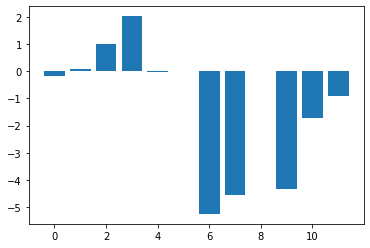

In [36]:
# get importance logistic
from matplotlib import pyplot

x=data.drop('response',axis=1).columns

logreg.fit(x_train,y_train)
importance = logreg.coef_[0]
# summarize feature importance
for x,v in zip(x,importance):
	print('Feature: %s, Score: %.5f' % (x,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

>> The following are important parameters for gaining more 'Yes' results:
* platform_os
* browser_Facebook
* experiment
* device make


<AxesSubplot:xlabel='Feature'>

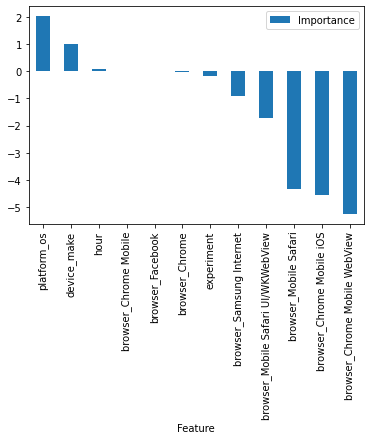

In [39]:
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot(kind='bar')

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

#### XGBoost Feature Importance

In [40]:
xgb_cv.fit(x_train,y_train)
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': xgb_cv.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
browser_Mobile Safari,0.542575
browser_Chrome Mobile iOS,0.315954
device_make,0.088342
browser_Chrome Mobile WebView,0.051394
experiment,0.000868
hour,0.000681
browser_Chrome,0.000185
platform_os,0.000000
browser_Chrome Mobile,0.000000


In [44]:
importances

,Importance
Feature,
browser_Mobile Safari,0.542575
browser_Chrome Mobile iOS,0.315954
device_make,0.088342
browser_Chrome Mobile WebView,0.051394
experiment,0.000868
hour,0.000681
browser_Chrome,0.000185
platform_os,0.000000
browser_Chrome Mobile,0.000000


>> The following are important features for the XGBoost model:
* device_make
* browser(Facebook,Samsung Internet,Chrome Mobile)
* experiment

<AxesSubplot:xlabel='Feature'>

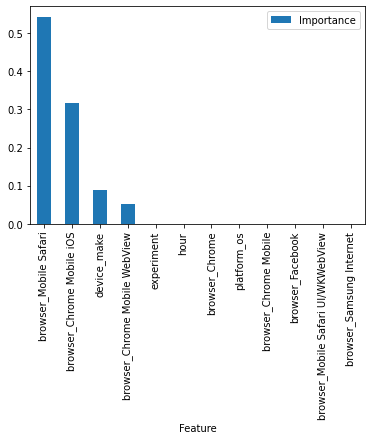

In [41]:
importances.plot(kind='bar')

#### Decision Tree Feature Importance

Feature: experiment , Score: 0.00000
Feature: hour , Score: 0.00000
Feature: device_make , Score: 0.42874
Feature: platform_os , Score: 0.00000
Feature: browser_Chrome , Score: 0.00000
Feature: browser_Chrome Mobile , Score: 0.00000
Feature: browser_Chrome Mobile WebView , Score: 0.02554
Feature: browser_Chrome Mobile iOS , Score: 0.20978
Feature: browser_Facebook , Score: 0.00000
Feature: browser_Mobile Safari , Score: 0.33594
Feature: browser_Mobile Safari UI/WKWebView , Score: 0.00000
Feature: browser_Samsung Internet , Score: 0.00000


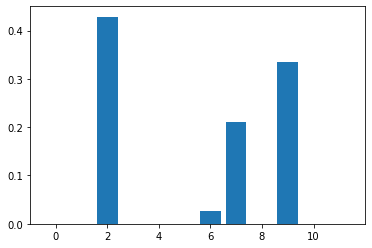

In [42]:
# get importance for decision

x=data.drop('response',axis=1).columns

decision_tree.fit(x_train,y_train)
importance = decision_tree.feature_importances_
# summarize feature importance
for x,v in zip(x,importance):
	print('Feature: %s , Score: %.5f' % (x,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [43]:
importances

,Importance
Feature,
browser_Mobile Safari,0.542575
browser_Chrome Mobile iOS,0.315954
device_make,0.088342
browser_Chrome Mobile WebView,0.051394
experiment,0.000868
hour,0.000681
browser_Chrome,0.000185
platform_os,0.000000
browser_Chrome Mobile,0.000000


>> The following are important features for the Decision tree model:
* hour
* device_make
* browser(Samsung Internet,Chrome Mobile view)
* experiment

<AxesSubplot:xlabel='Feature'>

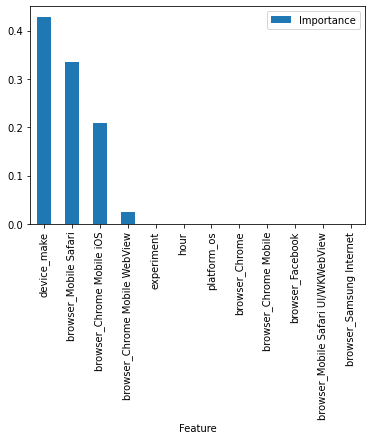

In [45]:
decision_tree.fit(x_train,y_train)
importances = pd.DataFrame({
    'Feature': data.drop('response', axis=1).columns,
    'Importance': decision_tree.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances.plot(kind='bar')